In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')



In [3]:
homedir = os.getenv("HOME")
sys.path.append(homedir+'/github/APPSS/')
from a100sdss import ks, anderson
sys.path.append(homedir+'/github/LCS/python/')
from LCScommon import *


Running on coma


# Strategy

### Paper 1

We compared the size ratio of infall galaxies to the core galaxies.

### Paper 2

* With the addition of the large field sample, we can compare the SFR distribution of the core galaxies with the field galaxies.


* we should use a mass-matched subsample of the field galaxies - draw a sample 10 times?  or draw 10 for each galaxy?  either way is probably fine.  We will compare the SFR distribution of the field and core.

* but how?  we really want to compare the core vs simulated galaxies in the SFR-Mstar plane.

* or could we just start with a mass-matched sample, decrease the SFRs at some rate, and then compare with the core?

* what does fraction of suppressed galaxies vs Mstar look like for the core vs infall vs field?

# How does SF MS evolve

$$ logSFR = \alpha(z) (logMstar - 10.5) + \beta(z)  $$



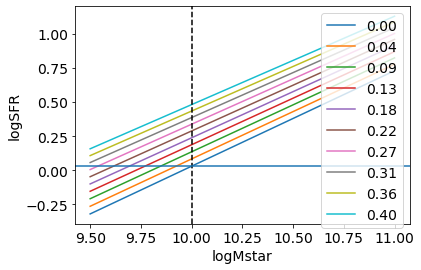

In [4]:
redshift = np.linspace(0,.4,10)
logMstar = np.linspace(9.5,11,100)
#redshift = np.array([0,.4])
#logMstar = 10
plt.figure()
for z in redshift:
    alpha = 0.7 - 0.13*z
    beta = 0.38 + 1.14*z - 0.19*z**2
    logSFR = alpha*(logMstar-10.5)+beta
    label = '{:.2f}'.format(z)
    #print(z,logSFR)
    plt.plot(logMstar,logSFR,label=label)
plt.legend()
plt.xlabel('logMstar')
plt.ylabel('logSFR')
plt.axvline(x=10,ls='--',c='k')
plt.axhline(y=.03)

# Modeling that we did spring/summer 2021

Previously, we took the field galaxies, assigned a random infall time, and then let the SFRs decline exponentially according to some timescale tau.  We also included a boost factor.
This is not correct, because we are using the field at $z=0$ as the starting point, but we should instead be using the field at the epoch of infall.

We figured out how to link (SFR, Mstar) of the present field galaxies with their (SFR_infall,Mstar_infall).  Instead of trying to work backward, we created a grid of galaxies with a range of stellar masses and SFRs (relative to the MS), corresponding to the max allowable infall time that we will assign (e.g. for tmax=3Gyr).  We then evolve these galaxies by stepping forward in time.  

The details of how we evolve a galaxy:  TBD

Once we have the stellar mass and SFR at the time of infall, we can let the SFR decline according to a timescale $\tau$ (we loop over a range of potential values for $\tau$) to simulate environmental quenching.

$$ SFR_{sim-core} = SFR_{infall}~ e^{-t_{infall}/\tau} $$

and mass evolves according to 

$$ M_{sim-core} = M_{infall} + \int_{t_{infall}}^0 SFR_{infall}~ e^{-t/\tau}~ f(t) dt $$

where $f(t)$ is the fraction of mass retained when the stellar pop has reached an age of t years.  We model this using the prescription from Poggianti+XX.

$$ f(t) = 1.749 - 0.125 log_{10}(t/yr) $$






# Getting SFR and Mstar at the time of infall

* we generate a grid of models that link the Mstar and SFR of galaxies through time
* this lets us link the $z=0$ field galaxies with their progenitors at the time of infall.
* we are assigning random infall times, so the grid allows the user to find the galaxy that is closest in terms of M(z=0), SFR(z=0) and infall time.
* I originally ran this for tmax = 3 Gyr.  Rerunning for tmax = 5 Gyr.  This should cover the full range of reasonable infall times (longer than 5 Gyr is probably not realistic).

* the program creates forward_model_sfms.fits in the current directory.  I am moving to ~/research/LCS/sfr_modeling/ before running so that the output file is stored there.

* this didn't complete with a certain combo of time steps.

In [35]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_mstar_forward_model.py --tmax 3 --ntimestep 50

<Figure size 489.6x360 with 0 Axes>

# Implementing a bit of multiprocessing (Aug 26, 2021)

* I converted SFR loop to multiprocessing
* also changed tmax to 7 Gyr, and increased number of timesteps to 70 so that we still have 10 timesteps per Gyr

In [292]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_mstar_forward_model.py --tmax 7 --ntimestep 70

CPU times: user 1.95 s, sys: 6.92 s, total: 8.87 s
Wall time: 1min 9s


# Writing out samples to use with SFR modeling

* we are using only $B/T < 0.4$ galaxies
* using $M < 9.7$, and $e < 0.75$
* the entire GSWLC catalog is written out
* the files are written to ~/research/LCS/tables
  * gsw-sfr-sim
  * lcs-sfr-sim
  
* these tables are read into LCSsimulate-infall-sfrs.py

* the modeling results are in another notebook

In [279]:
%run ~/github/LCS/python/lcs_paper2.py --cutBT --BT 0.4 --minmass 9.7 --ellip 0.75 
b.write_tables_for_SFR_sim()

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap-BTcut.fits
inside cut_BT, BT =  0.4
got sb flag
665 665 665 665
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.47
Best-fit inter = -4.88
Width of the MS = 0.22 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.47+/-0.01
Best-fit inter = -4.88+/-0.10


In [280]:
%run ~/github/LCS/python/lcs_paper2.py --minmass 9.7 --ellip 0.75 
b.write_tables_for_SFR_sim()

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
got sb flag
1269 1269 1269 1269
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.22
Width of the MS = 0.27 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.01
Best-fit inter = -4.22+/-0.11


# Running Simulations

* the simulations read in the sfr-sim.fits files
* they also utilize the grids from forward-model to create the field sample at the time of infall



In [6]:
def plot_sfrp_tau(tau,p_sfr):
    plt.figure()
    plt.plot(tau,p_sfr,'k.',alpha=.1)
    plt.axhline(y=.05)
    plt.xlabel(r'$\tau (Gyr)$')
    plt.ylabel('SFR p value')

Welcome!


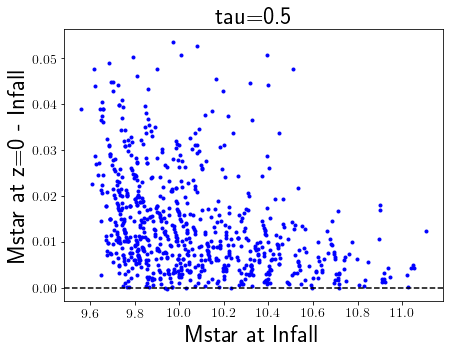

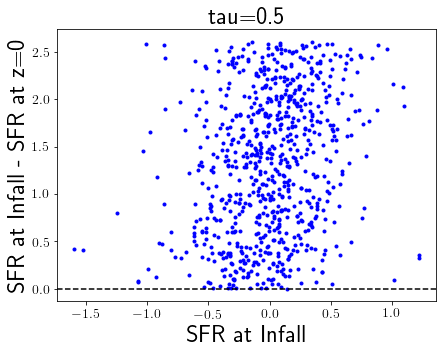

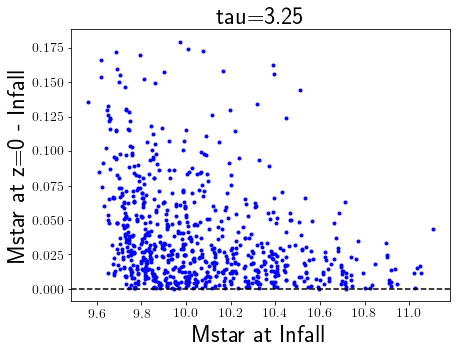

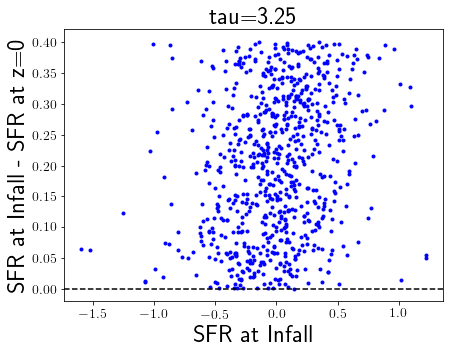

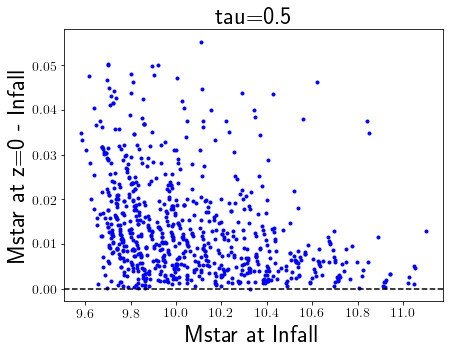

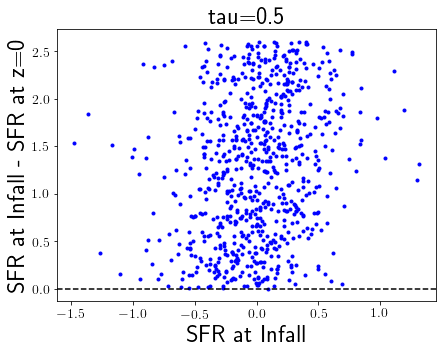

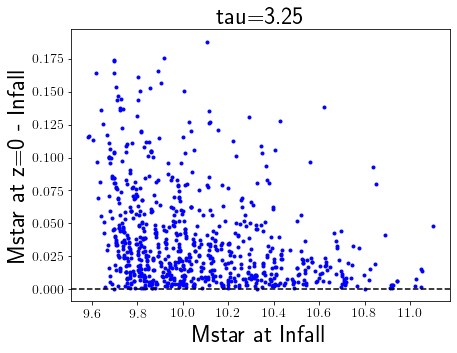

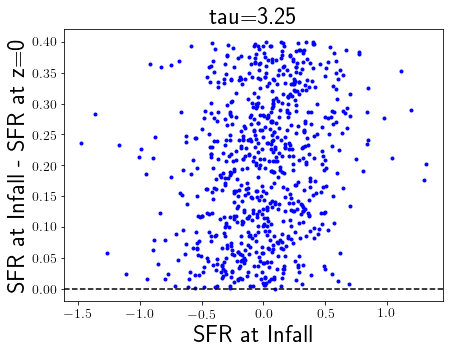

In [32]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t = run_sim(taumax=6,nstep_tau=2,nrandom=1,nmassmatch=5,tmax=3,debug=True)

In [33]:
all_tau,all_boost,all_p_sfr,all_p_dsfr,fquench_sfr = t

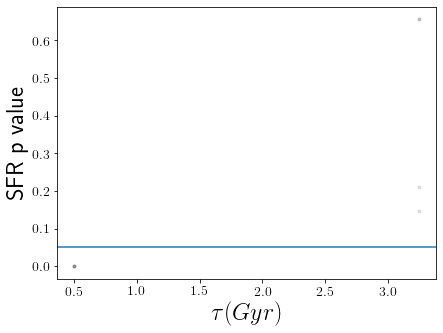

In [34]:
plot_sfrp_tau(all_tau,all_p_sfr)

# Updating August 26, 2021

* redid forward modeling grid to go back to 7 Gy ago
* need to rerun modeling to use tmax of 4,5,6,7

# tmax = 7 Gyr

In [294]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t7 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=10,tmax=7,debug=False)
all_tau7,all_boost7,all_p_sfr7,all_p_dsfr7,fquench_sfr7 = t7
#plot_frac_below_pvalue_sfr(all_tau5,all_p_sfr5,5,pvalue=.05)

Welcome!
getting sfr/mstar at infall
CPU times: user 6min 3s, sys: 1min 20s, total: 7min 24s
Wall time: 36min 14s


# tmax = 6 Gyr

In [310]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t6 = run_sim(taumax=7,nstep_tau=25,nrandom=10,nmassmatch=10,tmax=6,debug=False)
all_tau6,all_boost6,all_p_sfr6,all_p_dsfr6,fquench_sfr6 = t6

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 58s, sys: 1min 27s, total: 7min 26s
Wall time: 35min 34s


<Figure size 489.6x360 with 0 Axes>

# tmax = 5 Gyr

Welcome!
getting sfr/mstar at infall
pvalue =  0.05


(array([0.53156566, 0.7209596 , 0.97348485, 1.2260101 , 1.47853535,
        1.73106061, 1.98358586, 2.23611111, 2.48863636, 2.74116162,
        2.99368687, 3.24621212, 3.49873737, 3.75126263, 4.00378788,
        4.25631313, 4.50883838, 4.76136364, 5.01388889, 5.26641414,
        5.51893939, 5.77146465, 6.0239899 , 6.27651515, 6.5290404 ,
        6.71843434]),
 array([1.  , 1.  , 1.  , 1.  , 0.99, 0.93, 0.53, 0.13, 0.06, 0.04, 0.02,
        0.02, 0.03, 0.07, 0.33, 0.31, 0.52, 0.6 , 0.74, 0.75, 0.81, 0.82,
        0.91, 0.89, 0.92, 0.92]))

<Figure size 489.6x360 with 0 Axes>

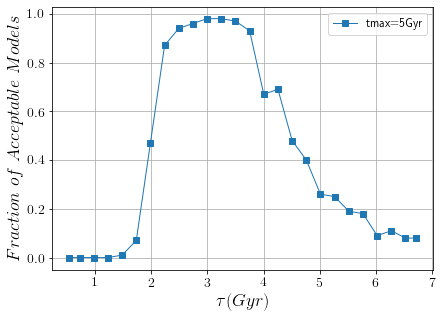

In [329]:
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t5 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=10,tmax=5,debug=False)
all_tau5,all_boost5,all_p_sfr5,all_p_dsfr5,fquench_sfr5 = t5
plot_frac_below_pvalue_sfr(all_tau5,all_p_sfr5,5,pvalue=.05)

# tmax = 4 Gyr

Welcome!
getting sfr/mstar at infall
pvalue =  0.05


(array([0.53156566, 0.7209596 , 0.97348485, 1.2260101 , 1.47853535,
        1.73106061, 1.98358586, 2.23611111, 2.48863636, 2.74116162,
        2.99368687, 3.24621212, 3.49873737, 3.75126263, 4.00378788,
        4.25631313, 4.50883838, 4.76136364, 5.01388889, 5.26641414,
        5.51893939, 5.77146465, 6.0239899 , 6.27651515, 6.5290404 ,
        6.71843434]),
 array([1.  , 1.  , 1.  , 1.  , 0.97, 0.59, 0.26, 0.06, 0.03, 0.01, 0.01,
        0.05, 0.03, 0.08, 0.28, 0.32, 0.42, 0.46, 0.62, 0.7 , 0.75, 0.77,
        0.82, 0.88, 0.87, 0.92]))

<Figure size 489.6x360 with 0 Axes>

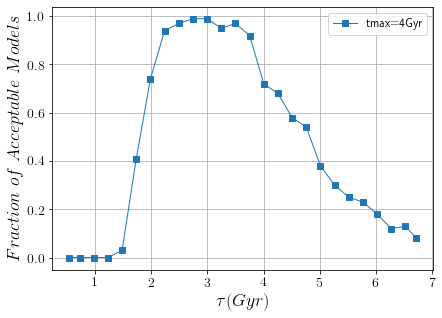

In [330]:
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t4 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=10,tmax=4,debug=False)
all_tau4,all_boost4,all_p_sfr4,all_p_dsfr4,fquench_sfr4 = t4
plot_frac_below_pvalue_sfr(all_tau4,all_p_sfr4,4,pvalue=.05)

# tmax = 3 Gyr

Welcome!
getting sfr/mstar at infall
pvalue =  0.05
CPU times: user 6min 20s, sys: 1min 29s, total: 7min 50s
Wall time: 36min 52s


(array([0.53156566, 0.7209596 , 0.97348485, 1.2260101 , 1.47853535,
        1.73106061, 1.98358586, 2.23611111, 2.48863636, 2.74116162,
        2.99368687, 3.24621212, 3.49873737, 3.75126263, 4.00378788,
        4.25631313, 4.50883838, 4.76136364, 5.01388889, 5.26641414,
        5.51893939, 5.77146465, 6.0239899 , 6.27651515, 6.5290404 ,
        6.71843434]),
 array([1.  , 1.  , 1.  , 0.94, 0.58, 0.25, 0.1 , 0.01, 0.  , 0.  , 0.01,
        0.04, 0.08, 0.18, 0.21, 0.38, 0.31, 0.46, 0.53, 0.54, 0.56, 0.73,
        0.67, 0.66, 0.77, 0.76]))

<Figure size 489.6x360 with 0 Axes>

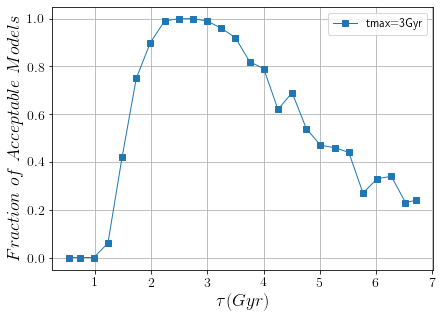

In [331]:
%%time
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t3 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=10,tmax=3,debug=False)
all_tau3,all_boost3,all_p_sfr3,all_p_dsfr3,fquench_sfr3 = t3
plot_frac_below_pvalue_sfr(all_tau3,all_p_sfr3,3,pvalue=.05)

update - the previous gsw-sfr-sim.fits table was mass matched to LCS core before it was written out.  I removed the mass matching so the full gsw sample is written out (as shown in paper figures, meaning mass, BT and ellip cuts are applied).  rerunning sim to see if anything changes significantly.

* apparently this takes A LOT longer to run.  The original file had 750 row.  the file with the full sample has 8872 rows! 

Welcome!
pvalue =  0.05


(array([0.52662037, 0.73958333, 0.9525463 , 1.16550926, 1.43171296,
        1.64467593, 1.85763889, 2.12384259, 2.33680556, 2.54976852,
        2.81597222, 3.02893519, 3.24189815, 3.45486111, 3.72106481,
        3.93402778, 4.14699074, 4.41319444, 4.62615741, 4.83912037,
        5.10532407, 5.31828704, 5.53125   , 5.74421296]),
 array([1.  , 1.  , 1.  , 0.99, 0.72, 0.31, 0.13, 0.06, 0.02, 0.  , 0.02,
        0.05, 0.03, 0.09, 0.14, 0.25, 0.36, 0.34, 0.43, 0.49, 0.55, 0.64,
        0.65, 0.61]))

<Figure size 489.6x360 with 0 Axes>

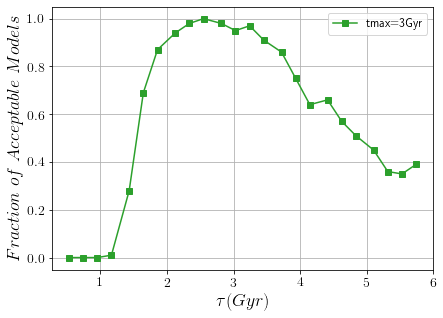

In [276]:
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
all_tau3,all_boost3,all_p_sfr3,all_p_dsfr3,fquench_sfr3 = t3
plot_frac_below_pvalue_sfr(all_tau3,all_p_sfr3,3,pvalue=.05,color=mycolors[2])

# tmax = 2 Gyr (DON'T NEED TO RERUN THESE - NOT REALISTIC VALUES)

Welcome!
pvalue =  0.05


<Figure size 489.6x360 with 0 Axes>

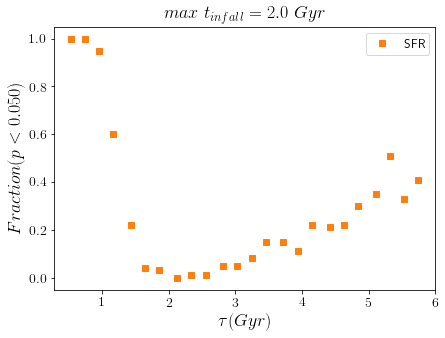

In [41]:
%%time
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t2 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=10,tmax=2,debug=False)
all_tau2,all_boost2,all_p_sfr2,all_p_dsfr2,fquench_sfr2 = t2
plot_frac_below_pvalue_sfr(all_tau2,all_p_sfr2,2,pvalue=.05)

# tmax = 1 Gyr

Welcome!
pvalue =  0.05


<Figure size 489.6x360 with 0 Axes>

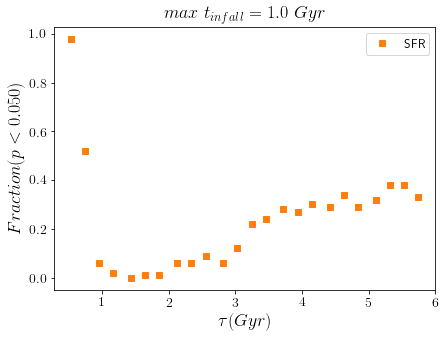

In [42]:
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t1 = run_sim(taumax=6,nstep_tau=24,nrandom=10,nmassmatch=10,tmax=1,debug=False)
all_tau1,all_boost1,all_p_sfr1,all_p_dsfr1,fquench_sfr1 = t1
plot_frac_below_pvalue_sfr(all_tau1,all_p_sfr1,1,pvalue=.05)

# Plot multiple values of tmax

* going to try showing all values of tmax

In [66]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome!
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003


<Figure size 489.6x360 with 0 Axes>

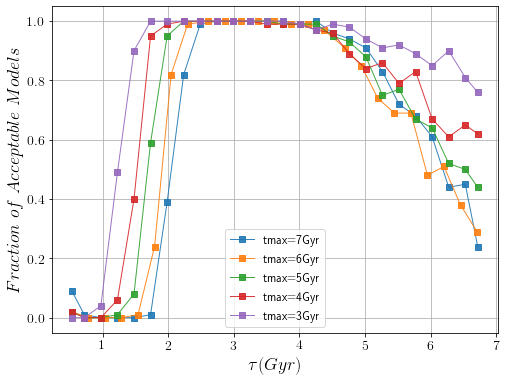

In [332]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
plt.figure(figsize=(8,6))
pcut = 0.003
t=plot_frac_below_pvalue_sfr(all_tau7,all_p_sfr7,7,pvalue=pcut,plotsingle=False,alpha=0.9)
t=plot_frac_below_pvalue_sfr(all_tau6,all_p_sfr6,6,pvalue=pcut,plotsingle=False,alpha=0.9)
t=plot_frac_below_pvalue_sfr(all_tau5,all_p_sfr5,5,pvalue=pcut,plotsingle=False,alpha=0.9)
t=plot_frac_below_pvalue_sfr(all_tau4,all_p_sfr4,4,pvalue=pcut,plotsingle=False,alpha=0.9)
t=plot_frac_below_pvalue_sfr(all_tau3,all_p_sfr3,3,pvalue=pcut,plotsingle=False,alpha=0.9)
#t=plot_frac_below_pvalue_sfr(all_tau2,all_p_sfr2,2,pvalue=.003,plotsingle=False,alpha=.3)
#t=plot_frac_below_pvalue_sfr(all_tau1,all_p_sfr1,1,pvalue=.003,plotsingle=False,alpha=.3)

# close plot
pvalue = pcut
plt.grid(b=True)
plt.legend()
plt.xlabel(r'$\tau (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)
output = 'frac_pvalue_sfr_infall_alltmax.png'
plt.savefig(output)
output = 'frac_pvalue_sfr_infall_alltmax.pdf'
plt.savefig(output)

Welcome!
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003


<Figure size 489.6x360 with 0 Axes>

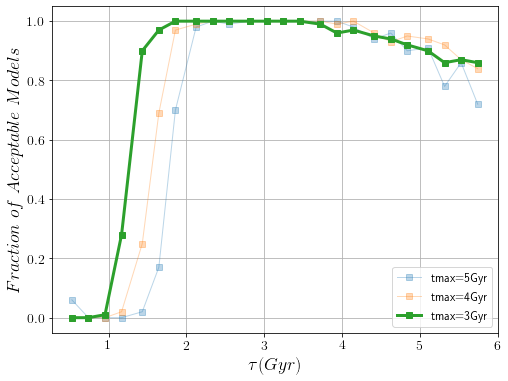

In [290]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
plt.figure(figsize=(8,6))
pvalue_cut = 0.003
t=plot_frac_below_pvalue_sfr(all_tau5,all_p_sfr5,5,pvalue=pvalue_cut,plotsingle=False,alpha=.3)
t=plot_frac_below_pvalue_sfr(all_tau4,all_p_sfr4,4,pvalue=pvalue_cut,plotsingle=False,alpha=.3)
t=plot_frac_below_pvalue_sfr(all_tau3,all_p_sfr3,3,pvalue=pvalue_cut,plotsingle=False,lw=3)
#t=plot_frac_below_pvalue_sfr(all_tau2,all_p_sfr2,2,pvalue=pvalue_cut,plotsingle=False,alpha=.3)
#t=plot_frac_below_pvalue_sfr(all_tau1,all_p_sfr1,1,pvalue=pvalue_cut,plotsingle=False,alpha=.3)

# close plot
pvalue = 0.05
plt.grid(b=True)
plt.legend()
plt.xlabel(r'$\tau (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)
output = 'frac_pvalue_sfr_infall_alltmax-pvalue003.png'
plt.savefig(output)
output = 'frac_pvalue_sfr_infall_alltmax-pvalue003.pdf'
plt.savefig(output)

# USING FULL SAMPLE (NOT BT < 0.4)

* Want to test the impact of the BT cut.
* it's not clear if we should limit the core sample to BT < 0.4, but we think that the bulge is growing as SFR decreases.
* we could also use the full sample, and then constrain the required increase in B/T for the core galaxies.  
  * this assumes that the BT distribution of z=0 field is the same as what the field would have at the time of infall.  this is probably not the case
  * in effect then, we would be specifying the min increase in B/T required

Welcome!
pvalue =  0.05


(array([0.02798822, 0.47579966, 0.97958754, 1.42739899, 1.87521044,
        2.32302189, 2.77083333, 3.27462121, 3.72243266, 4.17024411,
        4.61805556, 5.065867  , 5.51367845]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

<Figure size 489.6x360 with 0 Axes>

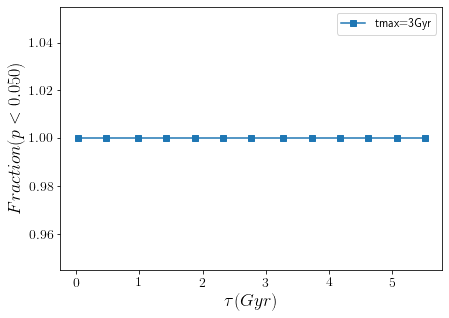

In [102]:
%%time
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py
all_tau3noBTcut,all_boost3noBTcut,all_p_sfr3noBTcut,all_p_dsfr3noBTcut,fquench_sfr3noBTcut = t3noBTcut
plot_frac_below_pvalue_sfr(all_tau3noBTcut,all_p_sfr3noBTcut,3,pvalue=.05)

In [ ]:
%%time
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs-mp.py
all_tau3noBTcut,all_boost3noBTcut,all_p_sfr3noBTcut,all_p_dsfr3noBTcut,fquench_sfr3noBTcut = t3noBTcut
plot_frac_below_pvalue_sfr(all_tau3noBTcut,all_p_sfr3noBTcut,3,pvalue=.05)

# Trying to parallelize modeling code

In [106]:
import multiprocessing as mp

In [108]:
nproc = mp.cpu_count()

In [132]:
%%time 
pool = mp.Pool(nproc)
results = [pool.apply(mass_match,args=(mass,external_logmstar)) for mass in masslist]
pool.close()

CPU times: user 59.4 ms, sys: 88.4 ms, total: 148 ms
Wall time: 34.5 s


In [181]:
%run ~/github/LCS/python/lcs_paper2.py

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
got sb flag
1334 1334 1334 1334
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.22
Width of the MS = 0.26 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.01
Best-fit inter = -4.22+/-0.10


In [182]:
results=[]
def collect_results(result):
    global results
    results.append(result)

In [232]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py

Welcome!


In [233]:
masslist = []
for i in range(10):
    masslist.append(core_logmstar)

In [234]:
%%time 
pool = mp.Pool(nproc)
for i,mass in enumerate(masslist):
    
    pool.apply_async(mass_match,args=(mass,external_logmstar,np.random.seed(8*i+17*i+78)),callback=collect_results)
pool.close()
pool.join()

CPU times: user 222 ms, sys: 462 ms, total: 684 ms
Wall time: 17.4 s


In [187]:
%%time
for i,m in enumerate(masslist):
    mass_match(m,external_logmstar,np.random.seed(2*i+17*i+78))


CPU times: user 48.7 s, sys: 92.2 ms, total: 48.8 s
Wall time: 48.6 s


In [210]:
tmax=3
nrandom=3
infall_times = np.linspace(0,tmax,len(external_sfr))
actual_infall_times = []
for i in range(nrandom):
    np.random.seed(3*i+31*i)
    actual_infall_times.append(np.random.choice(infall_times, len(infall_times)))


In [217]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py

Welcome!


In [212]:
infall_results=[]
def collect_results_infall(result):
    global infall_results
    infall_results.append(result)

In [219]:
%%time
print('getting sfr/mstar at infall')
infall_pool = mp.Pool(mp.cpu_count())
results2 = []
for i,infall_times in enumerate(actual_infall_times):
    results2.append(infall_pool.apply_async(get_sfr_mstar_at_infall,args=(np.log10(external_sfr),(external_logmstar),infall_times))) 
infall_pool.close()    
infall_pool.join()
infall_results2 = [r.get() for r in results2]

getting sfr/mstar at infall
CPU times: user 97.1 ms, sys: 249 ms, total: 346 ms
Wall time: 10.4 s


In [220]:
a,b,c = infall_results2[0]

In [201]:
%%time
print('getting sfr/mstar at infall')
infall_pool = mp.Pool(mp.cpu_count())
sync_results=[]
for i,infall_times in enumerate(actual_infall_times):
    sync_results.append(infall_pool.apply(get_sfr_mstar_at_infall,args=(np.log10(external_sfr),(external_logmstar),infall_times))) 
infall_pool.close()    
infall_pool.join()

getting sfr/mstar at infall
CPU times: user 560 ms, sys: 543 ms, total: 1.1 s
Wall time: 1min 2s


In [193]:
a,b = infall_results[0]

                                                                 

# Proceeding after parallel-processing updates

# running with and without BT cuts

* with parallel bits of code in place, it now takes 25 min to run modeling for each value of tmax
* I am rerunning tmax=3Gyr, with and without the BT cut, to see if the choice of BT cut affects our results
* the issue is that since SFR decline is linked with an increase in BT, it's not clear what the proper sample is to use.


In [248]:
%%time 
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs-mp.py --BTcut
mp_t3 = run_sim(taumax=5,nstep_tau=18,nrandom=10,nmassmatch=10,tmax=3,debug=False)


Welcome!
getting sfr/mstar at infall
CPU times: user 4min 16s, sys: 53.1 s, total: 5min 9s
Wall time: 24min 51s


<Figure size 489.6x360 with 0 Axes>

pvalue =  0.05


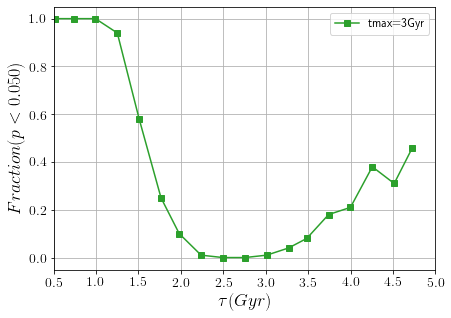

In [252]:
all_tau3mp,all_boost3mp,all_p_sfr3mp,all_p_dsfr3mp,fquench_sfr3mp = mp_t3
plot_frac_below_pvalue_sfr(all_tau3mp,all_p_sfr3mp,3,pvalue=.05,color=mycolors[2])
plt.xlim(0.5,5)
plt.grid()

(-0.05, 1.05)

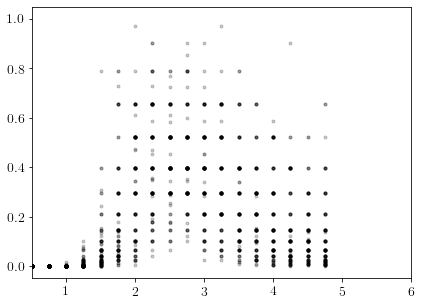

In [251]:
plt.figure()
plt.plot(all_tau3mp,all_p_sfr3mp,'k.',alpha=.2)
plt.xlim(0.5,6)
plt.ylim(-.05,1.05)

(-0.05, 1.05)

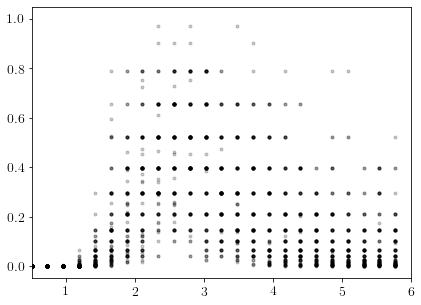

In [244]:
plt.figure()
plt.plot(all_tau3,all_p_sfr3,'k.',alpha=.2)
plt.xlim(0.5,6)
plt.ylim(-.05,1.05)

In [253]:
%%time 
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py 
mp_t3_noBTcut = run_sim(taumax=5,nstep_tau=18,nrandom=10,nmassmatch=10,tmax=3,debug=False)


Welcome!
getting sfr/mstar at infall
CPU times: user 5min 50s, sys: 1min 23s, total: 7min 13s
Wall time: 55min 6s


<Figure size 489.6x360 with 0 Axes>

pvalue =  0.05


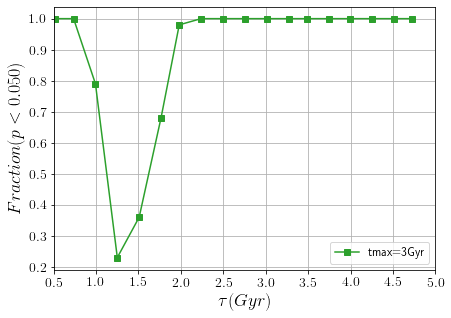

In [265]:
all_tau3mp_noBTcut,all_boost3mp_noBTcut,all_p_sfr3mp_noBTcut,all_p_dsfr3mp_noBTcut,fquench_sfr3mp_noBTcut = mp_t3_noBTcut
plot_frac_below_pvalue_sfr(all_tau3mp_noBTcut,all_p_sfr3mp_noBTcut,3,pvalue=.05,color=mycolors[2])
plt.xlim(0.5,5)
plt.grid()

In [271]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py

Welcome!


<Figure size 489.6x360 with 0 Axes>

pvalue =  0.05
pvalue =  0.05
pvalue =  0.05


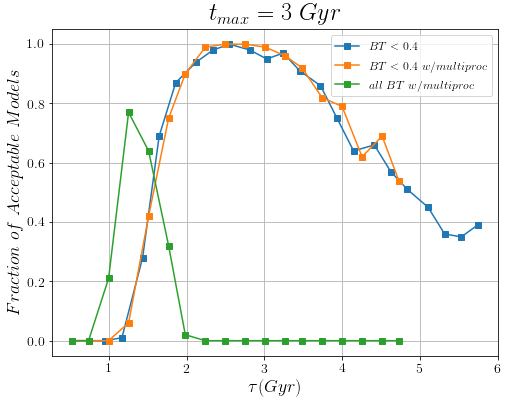

In [273]:
plt.figure(figsize=(8,6))
plot_frac_below_pvalue_sfr(all_tau3,all_p_sfr3,3,pvalue=.05,color=mycolors[0],plotsingle=False)
plot_frac_below_pvalue_sfr(all_tau3mp,all_p_sfr3mp,3,pvalue=.05,color=mycolors[1],plotsingle=False)
plot_frac_below_pvalue_sfr(all_tau3mp_noBTcut,all_p_sfr3mp_noBTcut,3,pvalue=.05,color=mycolors[2],plotsingle=False)
#plt.xlim(0.5,5)
#plt.grid()
plt.legend(['$BT < 0.4$','$BT < 0.4 \ w/multiproc$','$all \ BT \ w/multiproc$'])
plt.xlabel(r'$\tau (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)
plt.title('$t_{max} = 3~Gyr$')
output = 'frac_pvalue_sfr_infall_allBT.png'
plt.savefig(output)
output = 'frac_pvalue_sfr_infall_allBT.pdf'
plt.savefig(output)

# Modeling 0.4 < BT < 0.8 galaxies

* it doesn't make sense to model all galaxies together, because cluster has more $BT > 0.4$ galaxies than the field
* so the evolution timescale gets much shorter.
* trying instead to model high BT separately
* however, we could have alot of contamination from ellipticals within the cluster, so maybe this isn't a good idea...

In [281]:
%%time 
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --largeBT
mp_t3_highBT = run_sim(taumax=5,nstep_tau=18,nrandom=10,nmassmatch=10,tmax=3,debug=False)


Welcome!
getting sfr/mstar at infall
CPU times: user 1min 37s, sys: 42.9 s, total: 2min 20s
Wall time: 7min 46s


pvalue =  0.05


Text(0.5, 1, '$B/T > 0.4 \\ Galaxies$')

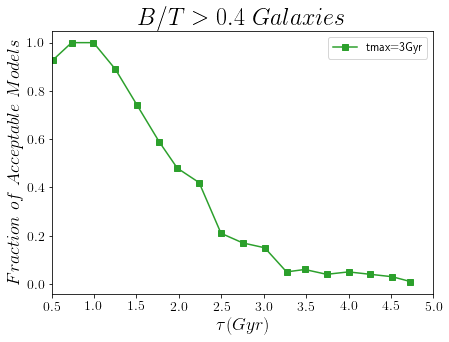

In [283]:
all_tau3mp_highBT,all_boost3mp_highBT,all_p_sfr3mp_highBT,all_p_dsfr3mp_highBT,fquench_sfr3mp_highBT = mp_t3_highBT
plot_frac_below_pvalue_sfr(all_tau3mp_highBT,all_p_sfr3mp_highBT,3,pvalue=.05,color=mycolors[2])
plt.xlim(0.5,5)
plt.grid()
plt.title('$B/T > 0.4 \ Galaxies$')

and now $0.4 < B/T < 0.8$

In [288]:
%%time 
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --largeBT
mp_t3_04BT08 = run_sim(taumax=5,nstep_tau=18,nrandom=10,nmassmatch=10,tmax=3,debug=False)


Welcome!
getting sfr/mstar at infall
CPU times: user 1min 24s, sys: 42 s, total: 2min 6s
Wall time: 5min 52s


<Figure size 489.6x360 with 0 Axes>

# COMPARISON OF DECLINE RATE RELATIVE TO FIELD

In [299]:
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from astropy import units as u

In [302]:
import sys, os
homedir = os.getenv("HOME")
sys.path.append(homedir+'/github/LCS/python/')
import sfr_mstar_forward_model as fm 

In [327]:
tmax = 6
best_tau = 4.3

median_tinfall = 0.5*tmax


cluster_evolution = np.exp(median_tinfall/best_tau)
# get redshift at this time
median_redshift = z_at_value(cosmo.lookback_time,median_tinfall*u.Gyr)
print('at lookback time of {:.1f}, redshift = {:.2f}'.format(median_tinfall, median_redshift))
# get evolution of the SF main sequence
logmstar = 9.7

redshift = np.array([0,median_redshift],'d')

logSFRs = SFR_MS(logmstar,redshift)

# calculate field evolution
SFRs = 10.**logSFRs

field_evolution = SFRs[1]/SFRs[0]
print('field evolution = {:.2f}'.format(field_evolution))

print('cluster evolution = {:.2f}'.format(cluster_evolution))

percent_difference = (cluster_evolution - field_evolution)/field_evolution
print('percent diff of cluster vs field = {:.1f}'.format(percent_difference*100))

print()
field_tau = -1*median_tinfall/(np.log(SFRs[0]/SFRs[1]))
print('equivalent e-folding time for field = {:.2f}'.format(field_tau))

at lookback time of 3.0, redshift = 0.25
field evolution = 2.00
cluster evolution = 2.01
percent diff of cluster vs field = 0.3

equivalent e-folding time for field = 4.32


# Setting min time to 1 Gyr

* lost this part when my computer crashed.  I included the plot in slack.  Basically, it's 

# Running with picking 10 field galaxies for each cluster galaxy in mass match

* lost this when my computer crashed
* going to rerun for tmax = 6 Gyr

In [37]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t6_ndraw10 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=10,tmax=6,debug=False)
all_tau6_ndraw10,all_boost6_ndraw10,all_p_sfr6_ndraw10,all_p_dsfr6_ndraw10,fquench_sfr6_ndraw10 = t6_ndraw10

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 25s, sys: 18 s, total: 5min 43s
Wall time: 21min 3s


In [36]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t6 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=10,ndrawmass=1,tmax=6,debug=False)
all_tau6,all_boost6,all_p_sfr6,all_p_dsfr6,fquench_sfr6 = t6

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 35s, sys: 18.4 s, total: 5min 54s
Wall time: 34min 10s


In [40]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t6_ndraw100 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=100,tmax=6,debug=False)
all_tau6_ndraw100,all_boost6_ndraw100,all_p_sfr6_ndraw100,all_p_dsfr6_ndraw100,fquench_sfr6_ndraw100 = t6_ndraw100

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 54s, sys: 31.4 s, total: 6min 26s
Wall time: 20min 51s


<Figure size 432x288 with 0 Axes>

/home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py:755: RuntimeWarning: invalid value encountered in true_divide
  y2 = t[0]/ytot


pvalue =  0.003


/home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py:755: RuntimeWarning: invalid value encountered in true_divide
  y2 = t[0]/ytot


pvalue =  0.003


Text(0, 0.5, '$Fraction \\ of \\ Acceptable \\ Models$')

<Figure size 432x288 with 0 Axes>

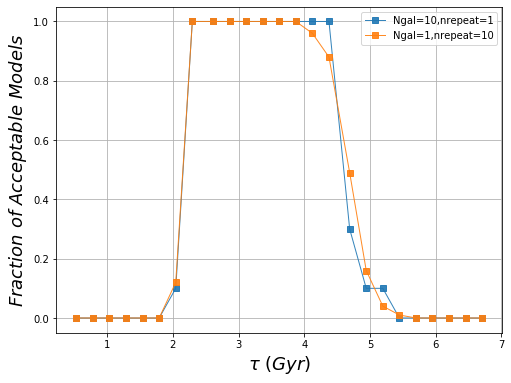

In [7]:
plt.figure()
plt.figure(figsize=(8,6))
pcut = 0.003
t=plot_frac_below_pvalue_sfr(all_tau6_ndraw10,all_p_sfr6_ndraw10,6,pvalue=pcut,plotsingle=False,alpha=0.9)

t=plot_frac_below_pvalue_sfr(all_tau6,all_p_sfr6,6,pvalue=pcut,plotsingle=False,alpha=0.9)


# close plot
pvalue = pcut
plt.grid(b=True)
#plt.legend()
plt.legend(['Ngal=10,nrepeat=1','Ngal=1,nrepeat=10'])
plt.xlabel(r'$\tau \ (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)


Welcome!
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003


Text(0, 0.5, '$Fraction \\ of \\ Acceptable \\ Models$')

<Figure size 432x288 with 0 Axes>

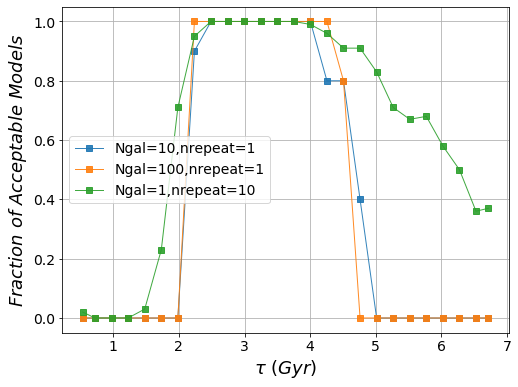

In [42]:
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
plt.figure()
plt.figure(figsize=(8,6))
pcut = 0.003
t=plot_frac_below_pvalue_sfr(all_tau6_ndraw10,all_p_sfr6_ndraw10,6,pvalue=pcut,plotsingle=False,alpha=0.9)
t=plot_frac_below_pvalue_sfr(all_tau6_ndraw100,all_p_sfr6_ndraw100,6,pvalue=pcut,plotsingle=False,alpha=0.9)
t=plot_frac_below_pvalue_sfr(all_tau6,all_p_sfr6,6,pvalue=pcut,plotsingle=False,alpha=0.9)


# close plot
pvalue = pcut
plt.grid(b=True)
plt.legend()
plt.legend(['Ngal=10,nrepeat=1','Ngal=100,nrepeat=1','Ngal=1,nrepeat=10'])

plt.xlabel(r'$\tau \ (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)


# comparing properties of the sim-core galaxies w/nmatch=1 vs 10

In [57]:
nmm1_d10 = Table.read('simcore_tmax6_ninfall10_nmassmatch1_ndrawmass10.fits')
nmm1_d100 = Table.read('simcore_tmax6_ninfall10_nmassmatch1_ndrawmass100.fits')
nmm10_d1 = Table.read('simcore_tmax6_ninfall10_nmassmatch10_ndrawmass1.fits')


logmstar
Ks_2sampResult(statistic=0.004820512820512823, pvalue=0.021533700221098604)

logsfr
Ks_2sampResult(statistic=0.0035435897435898145, pvalue=0.17271390277094656)

dlogsfr
Ks_2sampResult(statistic=0.004066666666666663, pvalue=0.07951716663554492)

tau
Ks_2sampResult(statistic=-0.0, pvalue=1.0)


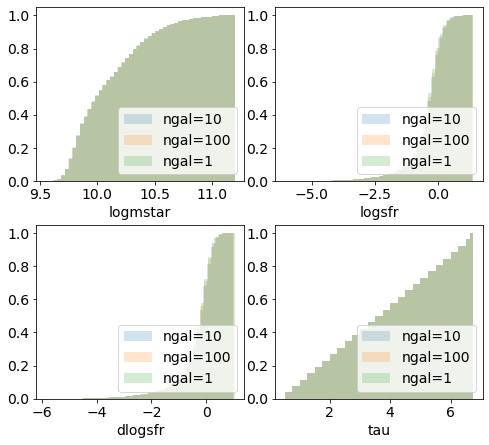

In [70]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=.25,wspace=.15,bottom=.2)
colnames = ['logmstar','logsfr','dlogsfr','tau']
for i,c in enumerate(colnames):
    plt.subplot(2,2,i+1)
    plt.hist(nmm1_d10[c],histtype='stepfilled',label='ngal=10',bins=50,alpha=.2,cumulative=True,normed=True)
    plt.hist(nmm1_d100[c],histtype='stepfilled',label='ngal=100',bins=50,alpha=.2,cumulative=True,normed=True)
    plt.hist(nmm10_d1[c],histtype='stepfilled',label='ngal=1',bins=50,alpha=.2,cumulative=True,normed=True)
    plt.legend(loc='lower right')
    plt.xlabel(c)
    print()
    print(c)
    t = ks_2samp(nmm1_d10[c],nmm10_d1[c])
    print(t)

# Saving sfr and stellar mass of sim-core galaxies

* want to test out the fastest way to save the data arrays

In [11]:
%run ~/github/LCS/python/speed_test.py

Computation time of appending the numpy array : 2.4365737438201904
Computation time of the list: 0.005640983581542969
Computation time of filling numpy array : 0.014104843139648438
Computation time of creating list implicitly : 0.0033578872680664062
Computation time of creating list from np.ones : 0.0004630088806152344


In [9]:
x = [1 for i in range(10)]

In [10]:
x


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
tmax=6.2
nrandom=10
nmassmatch=1
ndrawmass=10
newtab_name = 'simcore_tmax{:.0f}_ninfall{:d}_nmassmatch{:d}_ndrawmass{:d}.fits'.format(tmax,nrandom,nmassmatch,ndrawmass)
print(newtab_name)

simcore_tmax6_ninfall10_nmassmatch1_ndrawmass10.fits


In [35]:
6.5/26


0.25

In [64]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t7_ndraw10 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=10,tmax=7,debug=False)
#all_tau6_ndraw10,all_boost6_ndraw10,all_p_sfr6_ndraw10,all_p_dsfr6_ndraw10,fquench_sfr6_ndraw10 = t6_ndraw10

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 14s, sys: 26.2 s, total: 5min 40s
Wall time: 20min 48s


<Figure size 432x288 with 0 Axes>

In [65]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t5_ndraw10 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=10,tmax=5,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 22s, sys: 26 s, total: 5min 48s
Wall time: 21min 23s


In [66]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t4_ndraw10 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=10,tmax=4,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 5min 22s, sys: 26.5 s, total: 5min 48s
Wall time: 21min 11s


pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003


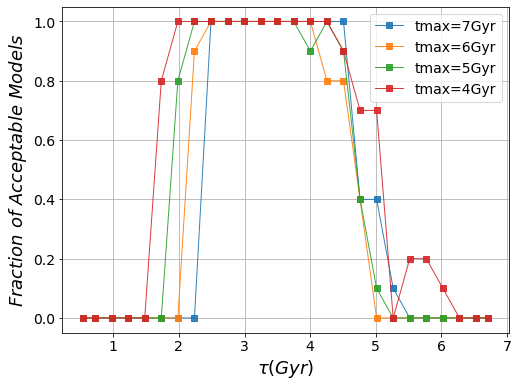

In [69]:
# plot results
plt.figure(figsize=(8,6))
inputs = [t7_ndraw10,t6_ndraw10,t5_ndraw10,t4_ndraw10]
times = [7,6,5,4]
for i,t in enumerate(inputs):
    all_tau,all_boost,all_p_sfr,all_p_dsfr,fquench_sfr = t
    k = plot_frac_below_pvalue_sfr(all_tau,all_p_sfr,times[i],pvalue=pcut,plotsingle=False,alpha=0.9)
    pvalue = pcut
plt.grid(b=True)
plt.legend()
plt.xlabel(r'$\tau (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)
output = 'frac_pvalue_sfr_infall_alltmax-ndraw10.png'
plt.savefig(output)
output = 'frac_pvalue_sfr_infall_alltmax-ndraw10.pdf'
plt.savefig(output)

# Repeating with drawing 60 sim-core galaxies per core galaxy

In [18]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t7_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=7,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 4min 1s, sys: 19.6 s, total: 4min 21s
Wall time: 15min 23s


<Figure size 432x288 with 0 Axes>

In [19]:
# just testing after the first run to see if the AD vs KS pvalues are sig different
all_tau,all_boost,all_p_sfr,all_p_dsfr,fquench_sfr,all_p_sfr_AD = t7_ndraw60


In [20]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t6_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=6,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 3min 59s, sys: 19.6 s, total: 4min 18s
Wall time: 15min 8s


In [21]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t5_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=5,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 3min 55s, sys: 19.2 s, total: 4min 14s
Wall time: 14min 47s


In [22]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t4_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=4,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 3min 58s, sys: 19.5 s, total: 4min 18s
Wall time: 15min 5s


In [23]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t3_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=3,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 3min 56s, sys: 18.9 s, total: 4min 15s
Wall time: 14min 50s


In [24]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t2_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=2,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 3min 54s, sys: 18.9 s, total: 4min 13s
Wall time: 14min 41s


In [25]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/LCSsimulate_infall_sfrs_mp.py --BTcut
t1_ndraw60 = run_sim(taumax=7,nstep_tau=26,nrandom=10,nmassmatch=1,ndrawmass=60,tmax=1,debug=False)

Welcome!
getting sfr/mstar at infall
CPU times: user 3min 55s, sys: 18.7 s, total: 4min 14s
Wall time: 14min 48s


pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003


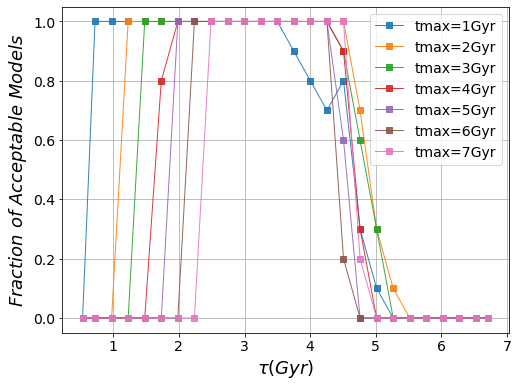

In [26]:
# plot results
plt.figure(figsize=(8,6))
inputs = [t1_ndraw60, t2_ndraw60, t3_ndraw60, t4_ndraw60,t5_ndraw60,t6_ndraw60,t7_ndraw60]
times = [1,2,3,4,5,6,7]
pcut=.003
for i,t in enumerate(inputs):
    all_tau,all_boost,all_p_sfr,all_p_dsfr,fquench_sfr,all_p_sfr_AD = t
    k = plot_frac_below_pvalue_sfr(all_tau,all_p_sfr,times[i],pvalue=pcut,plotsingle=False,alpha=0.9)
    pvalue = pcut
plt.grid(b=True)
plt.legend()
plt.xlabel(r'$\tau (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)
output = 'frac_pvalue_sfr_infall_alltmax-ndraw60.png'
plt.savefig(output)
output = 'frac_pvalue_sfr_infall_alltmax-ndraw60.pdf'
plt.savefig(output)

pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003
pvalue =  0.003


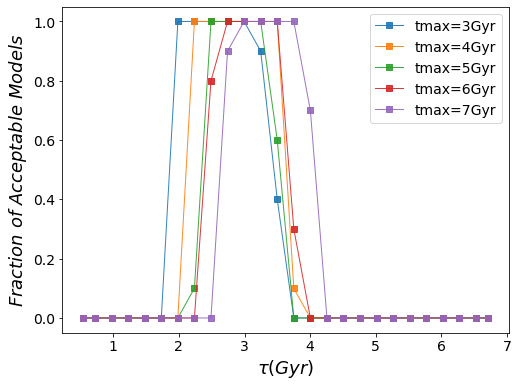

In [31]:
# plot results
plt.figure(figsize=(8,6))
inputs = [t3_ndraw60,t4_ndraw60,t5_ndraw60,t6_ndraw60,t7_ndraw60]
times = [3,4,5,6,7]
#inputs = [t1_ndraw60, t2_ndraw60, t3_ndraw60, t4_ndraw60,t5_ndraw60,t6_ndraw60,t7_ndraw60]
#times = [1,2,3,4,5,6,7]
pcut=.003
for i,t in enumerate(inputs):
    all_tau,all_boost,all_p_sfr,all_p_dsfr,fquench_sfr,all_p_sfr_AD = t
    k = plot_frac_below_pvalue_sfr(all_tau,all_p_sfr_AD,times[i],pvalue=pcut,plotsingle=False,alpha=0.9)
    pvalue = pcut
plt.grid(b=False)
plt.legend()
plt.xlabel(r'$\tau (Gyr)$',fontsize=18)
plt.ylabel(r'$Fraction \ of \ Acceptable \ Models$'.format(pvalue),fontsize=18)
output = 'frac_pvalue_sfr_AD_infall_alltmax-ndraw60.png'
plt.savefig(output)
output = 'frac_pvalue_sfr_AD_infall_alltmax-ndraw60.pdf'
plt.savefig(output)

# Using $\chi^2$ as a measure of goodness of fit


running main program
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax3_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax4_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax5_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax6_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax7_ninfall10_nmassmatch1_ndrawmass60.fits
CPU times: user 7.65 s, sys: 53.6 ms, total: 7.7 s
Wall time: 7.66 s


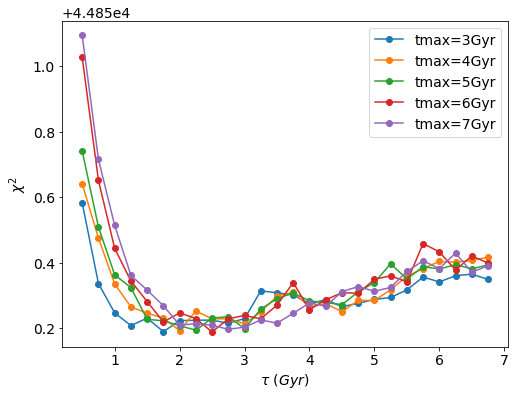

In [93]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_sim_max_liklihood.py

running main program
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax3_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax4_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax5_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax6_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax7_ninfall10_nmassmatch1_ndrawmass60.fits
CPU times: user 131 ms, sys: 132 ms, total: 263 ms
Wall time: 2.15 s


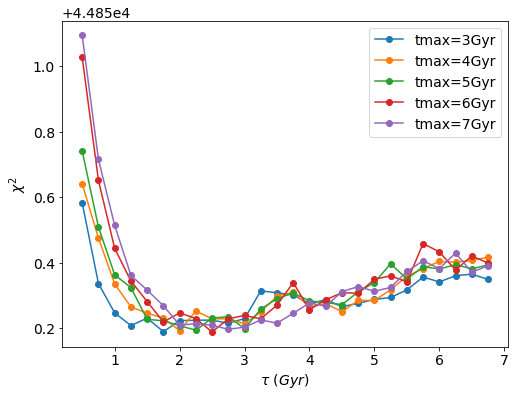

In [98]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_sim_max_liklihood.py

running main program
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax3_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax4_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax5_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax6_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax7_ninfall10_nmassmatch1_ndrawmass60.fits
CPU times: user 154 ms, sys: 156 ms, total: 310 ms
Wall time: 2.18 s


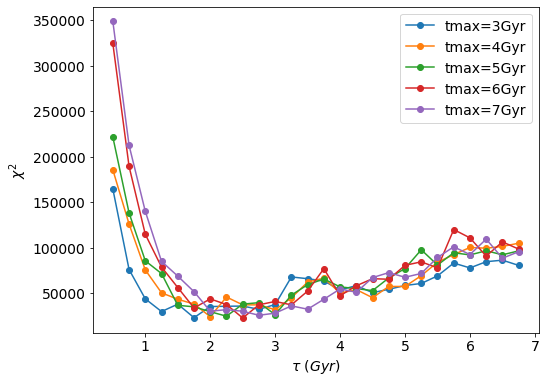

In [99]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_sim_max_liklihood.py

# Changed program to use maximum likelihood

running main program
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax3_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax4_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax5_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax6_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax7_ninfall10_nmassmatch1_ndrawmass60.fits
tmax=3Gyr
min at tau = [2.75], logL = 32.89188805234349
tmax=4Gyr
min at tau = [3.], logL = 32.01129249357209
tmax=5Gyr
min at tau = [3.], logL = 31.79797150235524
tmax=6Gyr
min at tau = [2.5], logL = 31.479345133776498
tmax=7Gyr
min at tau = [3.5], logL = 32.406045503367146
CPU times: user 187 ms, sys: 172 ms, total: 359 ms
Wall time: 2.11 s


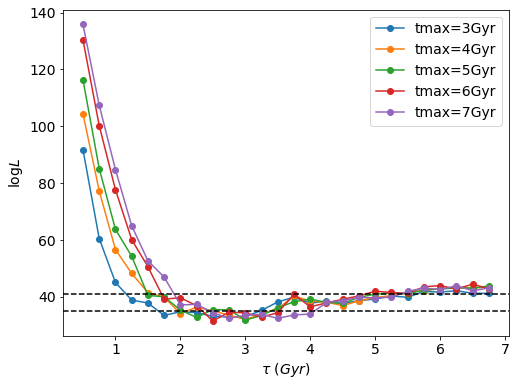

In [121]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_sim_max_liklihood.py
min_logL = 32
plt.axhline(y=min_logL+9,ls='--',color='k')
plt.axhline(y=min_logL+3,ls='--',color='k')

In [104]:
# calculating the t interval for 3sigma result, with sample size of LCS
import scipy.stats as st

In [122]:
ndata = len(lcs)
myalpha=.997
t_interval = st.t.interval(alpha=myalpha, df=ndata-1)
print(t_interval)

(-3.0691420291606866, 3.0691420291606737)


* in the figure above, I've marked where logL is 3 and 9 above the min logL (which is about 32).  
* still not sure if we use t or $t^2$
* this http://www.stat.ucla.edu/~hqxu/stat105/pdf/ch09.pdf document says the ratio approaches the t-test, or something like that...

# Next (Final) steps

* compute Anderson darling in addition to KS (rerun models, also calculating AD pvalue)

* then write up results, wrap up
 * KS test indicates 2-5 Gyr is acceptable
 * log likelihood indicates 2-4 Gyr is preferred, independent of tmax
 
* see if we can find out what value to use for the log ratio test

https://iopscience.iop.org/article/10.1088/0004-637X/799/2/226/pdf

http://articles.adsabs.harvard.edu/pdf/2002MNRAS.332...91D 



# updated code to calc log ratio

running main program
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax3_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax4_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax5_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax6_ninfall10_nmassmatch1_ndrawmass60.fits
/home/rfinn/research/LCS/sfr_modeling/simcore_tmax7_ninfall10_nmassmatch1_ndrawmass60.fits
tmax=3Gyr
min at tau = [2.75], logL = 88915.63006002357
tmax=4Gyr
min at tau = [3.], logL = 88914.19393952521
tmax=5Gyr
min at tau = [3.], logL = 88913.72859301128
tmax=6Gyr
min at tau = [3.25], logL = 88915.45596808323
tmax=7Gyr
min at tau = [3.5], logL = 88914.62425078393
CPU times: user 314 ms, sys: 168 ms, total: 482 ms
Wall time: 2.52 s


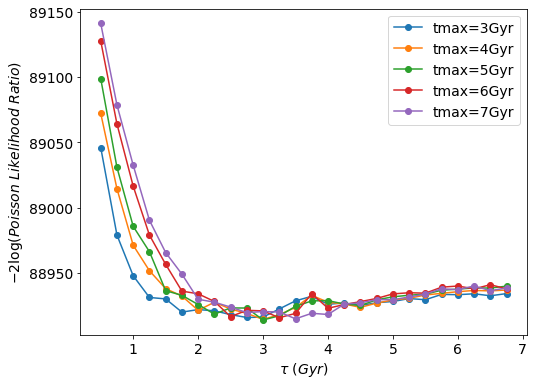

In [129]:
%%time 
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr_sim_max_liklihood.py
#min_logL = 32
#plt.axhline(y=min_logL+9,ls='--',color='k')
#plt.axhline(y=min_logL+3,ls='--',color='k')

In [125]:
0**0

1

In [130]:
log(1)

0.0